## tQST at work
In this notebook we are going to perform tQST in different ways:
* First we will see how to perform *t*QST on a 5-qubit $W$ state in a simulated way, without using experimental measurements.
* We will repeat the procedure for a random pure state.
* Then we will perform *t*QST of a 3-qubit $W$ state providing the measurements in two different ways.

First of all, we import the required dependencies for the simulated experiments.

In [1]:
import density_matrix_tool as dmt
import projectors_tQST_local as prj
import counts_tQST as cnt
from maximum_likelihood import *

## Tomography of a (simulated) 5-qubit $W$ state

Number of measurements: 52
Tomography of [2, 2, 2, 2, 2] using Triangular model with 1024 variables
Defaulting to L-BFGS-B method with options {'gtol': 0.0001, 'maxiter': 1000}
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL


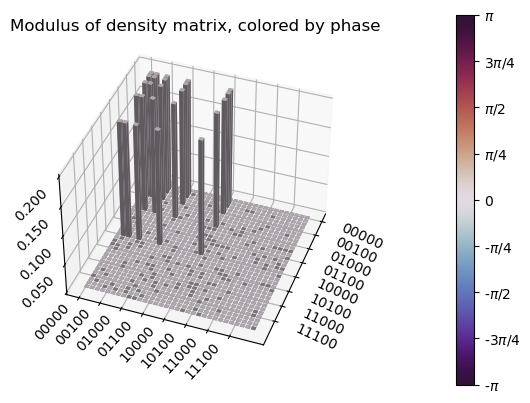

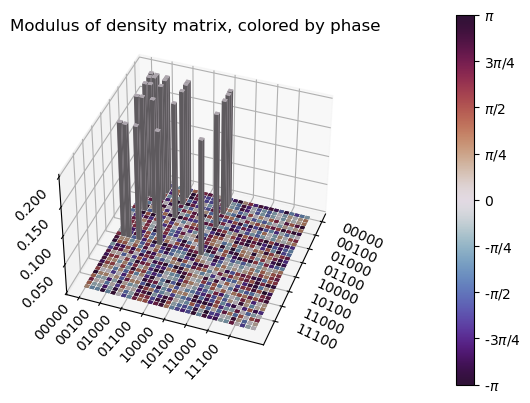

Fidelity with respect to the target state: 0.9973102889578408


In [5]:
nq  = 5
rho = dmt.density_matrix_W(nq)

P = prj.Projectors_tQST_qubit_local(nq)
C = cnt.Counts_tQST(P)

C.set_density_matrix(rho)
threshold = dmt.gini_index(np.diagonal(rho))
mel = C.get_matrix_elements_tQST(threshold)

# for x in mel[16:]:
#     print(P.projector_name_from_matrix_element(*x))

projs, counts = C.get_counts_from_mat_el(mel)
print('Number of measurements:', len(counts))

ml = Maximum_likelihood_tomography(nq, model=model_triangular)
ml.set_counts(projs, counts)
res = ml.minimize()
print(res.message)
rho_reconstructed = ml.model_density_matrix()

dmt.plot_density_matrix_3D(rho)
dmt.plot_density_matrix_3D(rho_reconstructed)
print('Fidelity with respect to the target state:', dmt.fidelity(rho_reconstructed, rho))

As one can see both from the plots and the fidelity, the result is remarkably good, and the reconstruction is very quick.  

## Tomography of a pure random, but known, state of 4 qubit

Number of measurements: 44
Tomography of [2, 2, 2, 2] using Triangular model with 256 variables
Defaulting to L-BFGS-B method with options {'gtol': 0.0001, 'maxiter': 1000}
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL


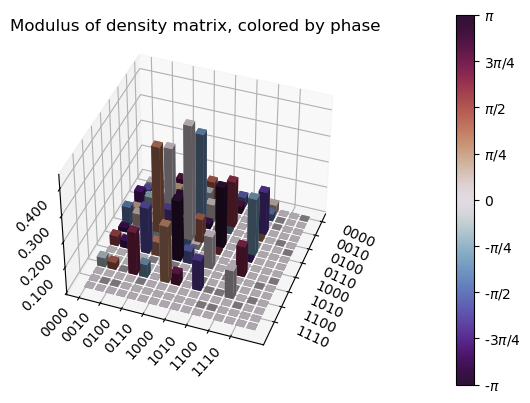

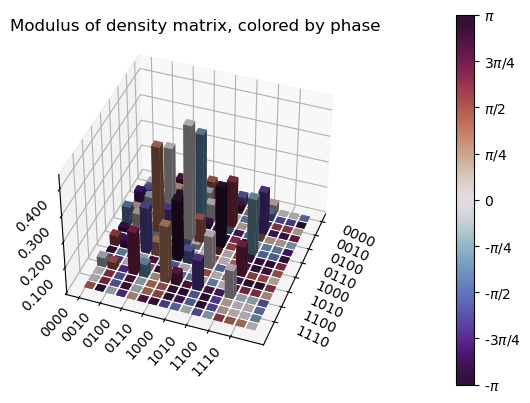

Fidelity with respect to the target state: 0.9997753548400841
Purity of the reconstructed state: 0.9991021108258387


In [3]:
nq = 4

rho_target = dmt.density_matrix_random(dimension = 2**nq, rank = 1, number_of_zeros = 8)

diag_els = np.diagonal(rho_target)

P = prj.Projectors_tQST_qubit_local(nq)

C = cnt.Counts_tQST(P)
C.set_density_matrix(rho_target)
threshold = dmt.gini_index(diag_els)
mel = C.get_matrix_elements_tQST(threshold,diag_els)

projs, counts = C.get_counts_from_mat_el(mel)
counts = counts * 1e3
print('Number of measurements:', len(projs))

ml = Maximum_likelihood_tomography(nq, model=model_triangular)
ml.set_counts(projs, counts)
res = ml.minimize()
print(res.message)
rho_reconstructed = ml.model_density_matrix()

dmt.plot_density_matrix_3D(rho_target)
dmt.plot_density_matrix_3D(rho_reconstructed)
print('Fidelity with respect to the target state:', dmt.fidelity(rho_target, rho_reconstructed))
print('Purity of the reconstructed state:', dmt.purity(rho_reconstructed))

## Tomography of a 3-qubit $W$ state (first method)
Now we try to perform *t*QST using "experimental" data, meaning that the diagonal and the counts are provided by the user. To this end, we will use methods of the ```tQST_class```. We briefly describe the workflow.
1. Suppose that you expect your system to generate a $W$ state. We generate a 3-qubit $W$ state to compute the fidelity at the end.
2. We call an instance of the ```tQST``` class, give as argument the number of qubits. The method ```get_num_of_qubits()``` let us retrieve and store the number of qubits in a variable.
3. We provide the diagonal counts and set them with the method ```set_diagonal_counts()```, which needs the diagonal counts as argument. The diagonal counts are ordered in the same way as the computational basis. In the case of 3 qubits, according to the definition of $\lvert 0 \rangle$ and $\lvert 1 \rangle$, the ordering is:
- $\lvert HHH \rangle \rightarrow 0$
- $\lvert HHV \rangle \rightarrow 1/3$
- $\lvert HVH \rangle \rightarrow 1/3$
- $\lvert HVV \rangle \rightarrow 0$
- $\lvert VHH \rangle \rightarrow 1/3$
- $\lvert VHV \rangle \rightarrow 0$
- $\lvert VVH \rangle \rightarrow 0$
- $\lvert VVV \rangle \rightarrow 0$
4. We choose the threshold and set it with the method ```set_threshold()```, which needs the threshold value as argument.
5. The projectors to be measured are stored in the list ```offd_projs``` by calling the method ```get_projs_to_measure()```. This will also print a table corresponding to the measurements required to perform tQST, given the diagonal counts and the threshold provided by the user.
6. We create a list ```offd_counts``` and put the measured counts in it. Then we call the method ```set_projs_and_counts()```, with arguments ```offd_projs``` and ```offd_counts```.
7. We then call the method ```get_projs_and_counts()``` and store all the measured projectors and counts in two arrays, called ```projs``` and ```counts```.
8. We set the model of the density matrix for the maximum likelihood minimization. ```model_triangular``` is a good choice.
9. We call the ```get_density_matrix()``` method to work out the maximum likelihood minimization. It returns the reconstructed density matrix, which we store in the ```rho_rec``` variable. 
10. Finally, we plot the reconstructed density matrix, and compute the fidelity between this and the target state.

Number of qubits set to 3.
Diagonal counts are now set.
The threshold is now set to 0.08928571428571429.
These are the projectors you have to measure, given the provided diagonal and threshold.
+----------------+-----------+
| Matrix element | Projector |
+----------------+-----------+
|  (1, 2, 'r')   |   |HRR>   |
|  (1, 2, 'i')   |   |HRD>   |
|  (1, 4, 'r')   |   |RHR>   |
|  (1, 4, 'i')   |   |RHD>   |
|  (2, 4, 'r')   |   |RRH>   |
|  (2, 4, 'i')   |   |RDH>   |
+----------------+-----------+
The model for density matrix reconstruction is now set.
Tomography of [2, 2, 2] using Triangular model with 64 variables
Defaulting to L-BFGS-B method with options {'gtol': 0.0001, 'maxiter': 1000}
The projectors and the corresponding counts are set. Ready to perform QST.
14


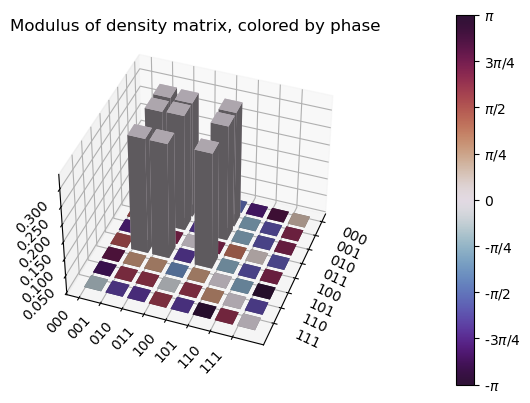

Fidelity with respect to the target state: 0.9982467453550157


In [2]:
from tqst_class import *

rho = dmt.density_matrix_W(3)

tomo = tQST(3)
nq = tomo.get_num_of_qubits()

diagonal = [0., 333, 333, 0., 333, 0., 0., 0.]
N = np.sum(diagonal)
tomo.set_diagonal_counts(diagonal)

threshold = dmt.gini_index(diagonal)
tomo.set_threshold(threshold)

offd_projs = tomo.get_projs_to_measure()

offd_counts = [333, 167, 333, 167, 333, 167]/N

tomo.set_projs_and_counts(offd_projs, offd_counts)
projs, counts = tomo.get_projs_and_counts()

tomo.set_density_matrix_model(model_triangular)

rho_rec = tomo.get_density_matrix(projs, counts)
print(len(projs))
dmt.plot_density_matrix_3D(rho_rec)
print('Fidelity with respect to the target state:', dmt.fidelity(rho, rho_rec))


# Tomography of a 3-qubit $W$ state (second method)
Here we perform tQST as in the previous cell code, but we provide the projectors and the counts in a different way. 

1. The system is still supposed to generate a $W$ state. We generate a 3-qubit $W$ state to compute the fidelity at the end.
2. We call an instance of the ```tQST``` class, give as argument the number of qubits. The method ```get_num_of_qubits()``` let us retrieve and store the number of qubits in a variable.
3. We provide the diagonal counts and set them with the method ```set_diagonal_counts()```, which needs the diagonal counts as argument. The method ```get_diagonal_counts()``` returns a dictionary containing the projectors and the measured diagonal elements as key-value pairs. This is the dictionary we will upload with the projectors and the counts. The diagonal counts are ordered in the same way as the computational basis. In the case of 3 qubits, according to the definition of $\lvert 0 \rangle$ and $\lvert 1 \rangle$, the ordering is:
- $\lvert HHH \rangle \rightarrow 0$
- $\lvert HHV \rangle \rightarrow 1/3$
- $\lvert HVH \rangle \rightarrow 1/3$
- $\lvert HVV \rangle \rightarrow 0$
- $\lvert VHH \rangle \rightarrow 1/3$
- $\lvert VHV \rangle \rightarrow 0$
- $\lvert VVH \rangle \rightarrow 0$
- $\lvert VVV \rangle \rightarrow 0$
4. We choose the threshold and set it with the method ```set_threshold()```, which needs the threshold value as argument.
5. We call the method ```get_projectors_to_measure()```, which returns a list containing the projectors to measure. 
6. By using the standard Python dictionary method ```setdefault()```, with the projectors as keys and the corresponding counts as arguments, we update the dictionary with the measurement outcomes.
7. We call the ```read_tomo_dictionary()``` method to set projectors and counts.
8. We set the model of the density matrix for the maximum likelihood minimization. ```model_triangular``` is a good choice.
9. We call the ```get_density_matrix()``` method to work out the maximum likelihood minimization. It returns the reconstructed density matrix, stored in the ```rho_rec``` variable. 
10. Finally, we plot the reconstructed density matrix, and compute the fidelity between this and the target state.

Number of qubits set to 3.
Diagonal counts are now set.
The threshold is now set to 0.08928571428571429.
These are the projectors you have to measure, given the provided diagonal and threshold.
+----------------+-----------+
| Matrix element | Projector |
+----------------+-----------+
|  (1, 2, 'r')   |   |HRR>   |
|  (1, 2, 'i')   |   |HRD>   |
|  (1, 4, 'r')   |   |RHR>   |
|  (1, 4, 'i')   |   |RHD>   |
|  (2, 4, 'r')   |   |RRH>   |
|  (2, 4, 'i')   |   |RDH>   |
+----------------+-----------+
The model for density matrix reconstruction is now set.
Tomography of [2, 2, 2] using Triangular model with 64 variables
Defaulting to L-BFGS-B method with options {'gtol': 0.0001, 'maxiter': 1000}
The projectors and the corresponding counts are set. Ready to perform QST.


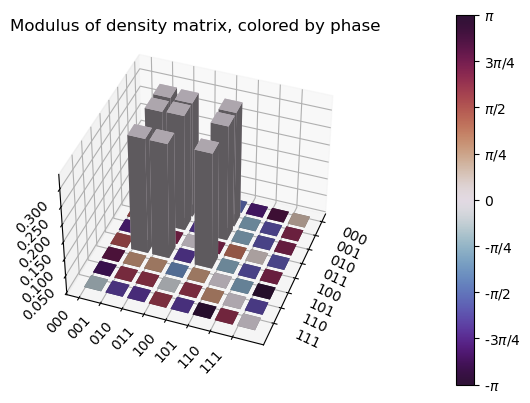

Fidelity with respect to the target state: 0.9982467453550157


In [6]:
rho = dmt.density_matrix_W(3)

tomo = tQST(3)
nq  = tomo.get_num_of_qubits()

diagonal = [0., 333, 333, 0., 333, 0., 0., 0.]
N = np.sum(diagonal)
tomo.set_diagonal_counts(diagonal)
tdict = tomo.get_diagonal_counts()

threshold = dmt.gini_index(diagonal)
tomo.set_threshold(threshold)

proj_to_meas = tomo.get_projectors_to_measure()

tdict.setdefault('HRR', 333/N)
tdict.setdefault('HRD', 167/N)
tdict.setdefault('RHR', 333/N)
tdict.setdefault('RHD', 167/N)
tdict.setdefault('RRH', 333/N)
tdict.setdefault('RDH', 167/N)

projs, counts = tomo.read_tomo_dictionary(tdict)

tomo.set_density_matrix_model(model_triangular)

rho_rec = tomo.get_density_matrix(projs, counts)
dmt.plot_density_matrix_3D(rho_rec)
print('Fidelity with respect to the target state:', dmt.fidelity(rho, rho_rec))

At this point, we can make some comments on the results. The fidelity of the 3-qubit *W* state reconstructed with *t*QST is above 99%, and it required only 14 measurements. The overcomplete tomography would have required $6^3 = 216$ measurements, while the complete tomography $4^3 = 64$. All the experiments were done with noiseless data. The reduction of the experimental effort required with *t*QST is clear, and becomes more and more evident when the number of qubits increases.